# ロボットの移動ばらつきパラメータを求める

In [3]:
import sys
sys.path.append('../src')
import importlib

import worlds
import maps
import numpy as np
import robots
import sensors
import agents
import landmarks
import estimators
import particles

def reload():
    importlib.reload(worlds)
    importlib.reload(maps)
    importlib.reload(robots)
    importlib.reload(sensors)
    importlib.reload(agents)
    importlib.reload(estimators)
    importlib.reload(particles)

<IPython.core.display.Javascript object>


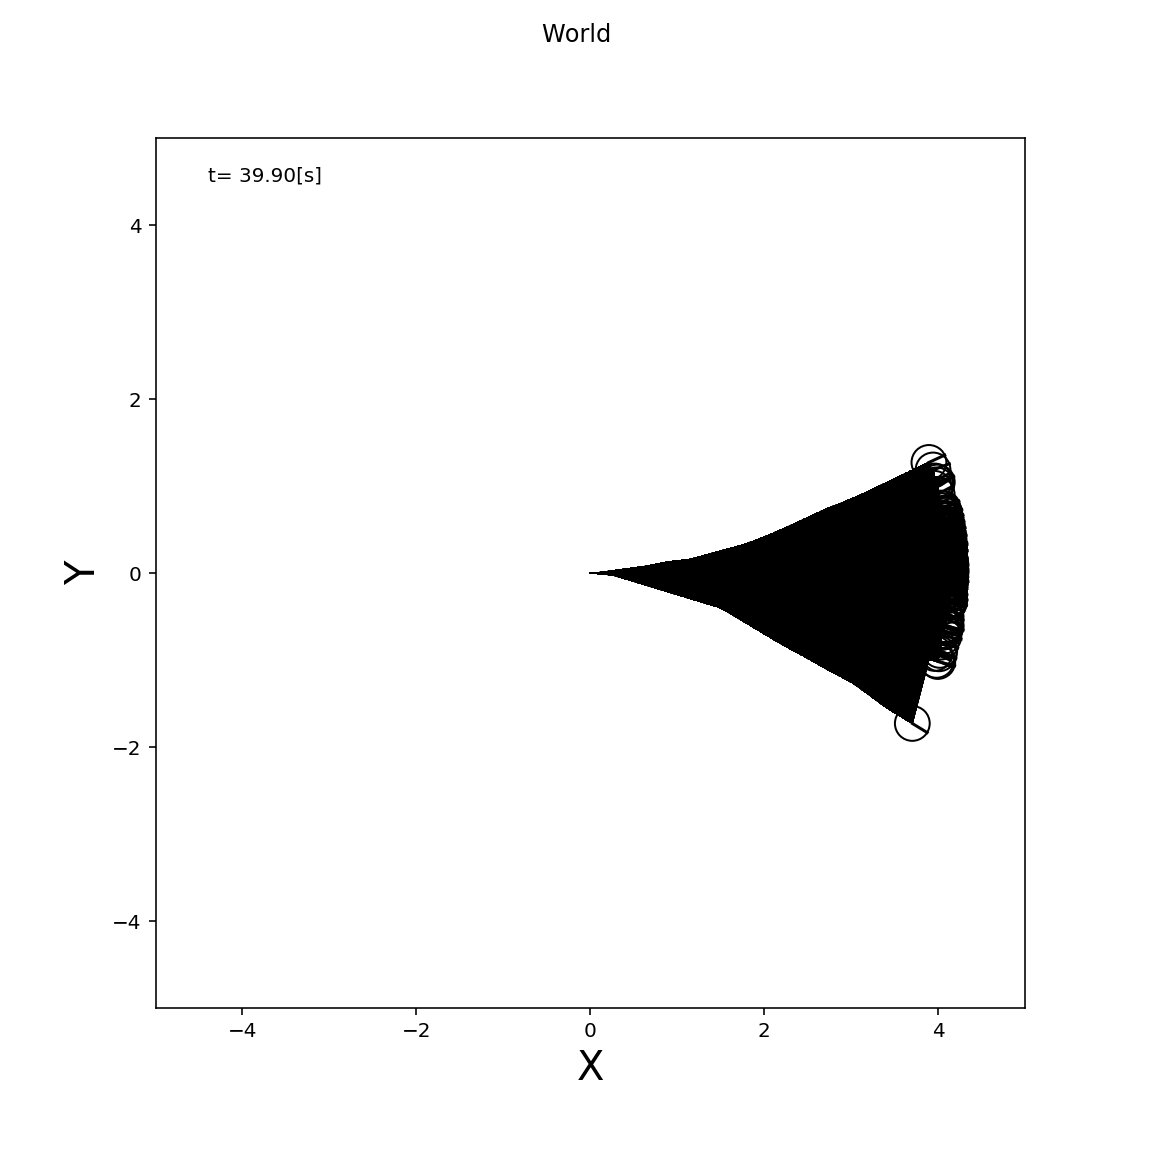

In [7]:
# ロボットを
# 0.1[m/s]で
# 4.0[m]走らせて
# 移動後の姿勢を記録する
# それを100回する

import copy

world = worlds.World(40., 0.1, debuggable=True)

initial_pose = np.array([0.,0.,0.])

robot = robots.Robot(initial_pose, sensor=None, agent=agents.Agent(0.1, 0.0))
robots_ = []

for i in range(100):
    # 大本のロボットは使い回す
    # 道のりのばらつき以外のばらつきを統一するため
    copy_r = copy.copy(robot)
    copy_r.distance_until_noise = copy_r.noise_pdf.rvs()
    world.append(copy_r)
    robots_.append(copy_r)
    
world.draw()

In [9]:
# ↑の処理はめっちゃ時間かかかる
import math
import pandas as pd

# 距離rと姿勢theta
poses = pd.DataFrame(
    [[math.sqrt(r.pose[0]**2 + r.pose[1]**2), r.pose[2]] for r in robots_],
    columns=['r', 'theta'])
poses.transpose()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
r,4.138208,4.135669,4.143303,4.123498,4.123486,4.143636,4.150696,4.139635,4.124555,4.116792,...,4.133808,4.095192,4.148029,4.149641,4.130539,4.104828,4.130418,4.128487,4.14636,4.130205
theta,0.099584,0.261909,0.056196,0.006939,0.114525,0.148705,0.036046,-0.053562,0.364875,0.357980,...,0.333421,-0.549148,0.057307,0.096929,-0.327743,0.341665,0.278884,-0.278428,-0.23617,-0.318463


In [21]:
# 姿勢のばらつきと距離の平均から，直進が回転に与えるばらつきを求める

print(poses['theta'].var())
print(poses['r'].mean())

# 分散の大きさが距離に比例するなら (var / mean)^(1/2)が1[m]あたりの直進が回転に与える標準偏差になる
sigma_omega_nu = poses['theta'].var() / poses['r'].mean()
math.sqrt(sigma_omega_nu)

0.057025855249248913
3.945013039371295


0.1202296775001906

<IPython.core.display.Javascript object>


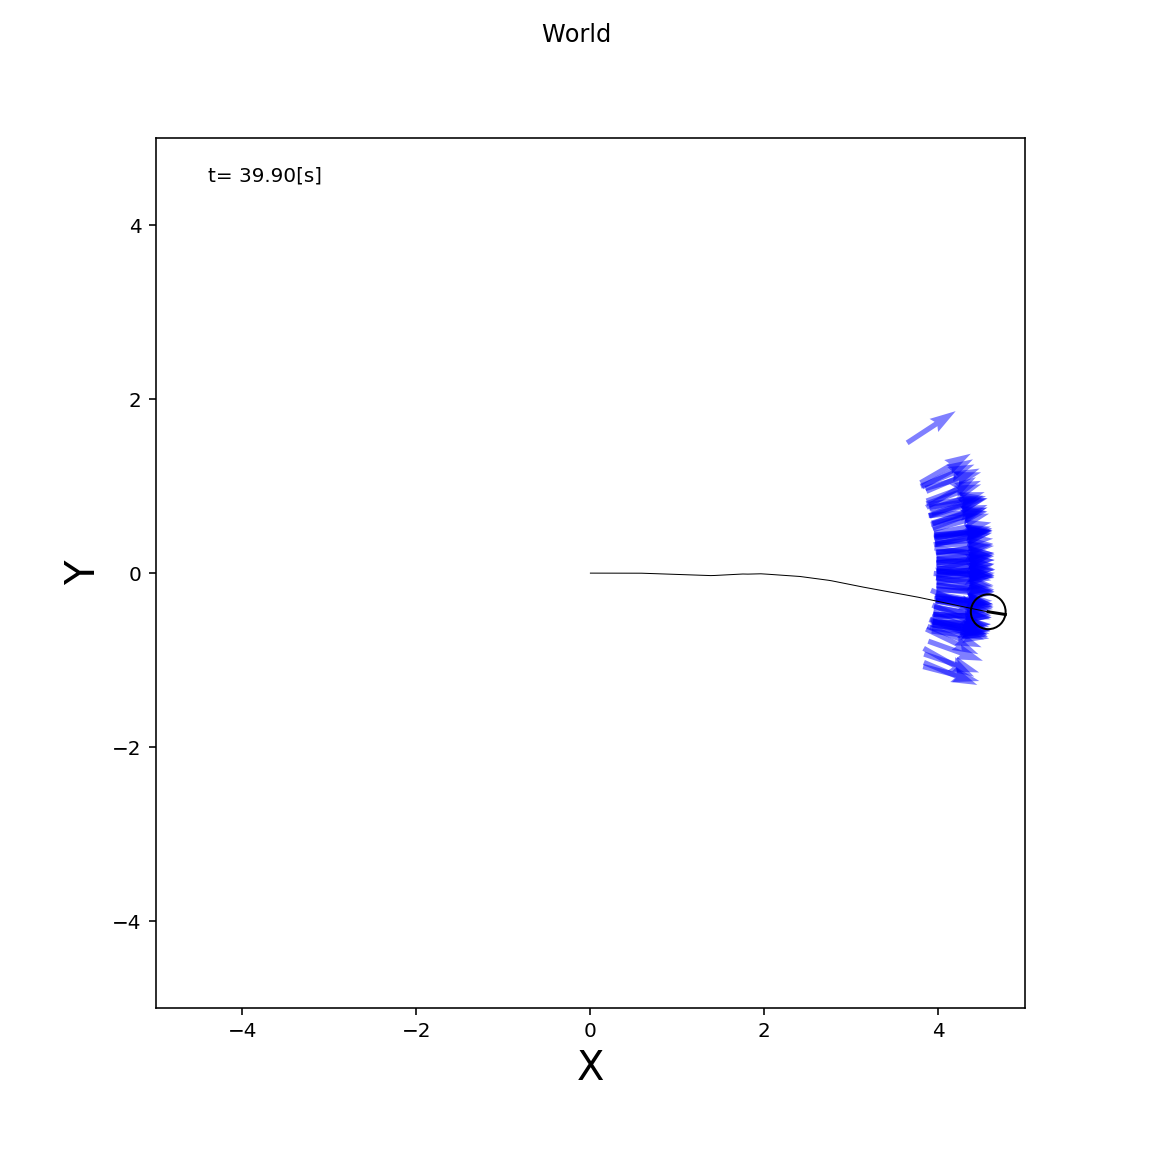

In [14]:
# 得られた値でパーティクルを動かしてみる
# さっきのロボット100台シミュレーションの結果と似ているのでは

world = worlds.World(40., 0.1, debuggable=False)

initial_pose = np.array([0.,0.,0.])
# on以外は小さな値にしておく
estimator = estimators.Mcl(
    initial_pose, 100,
    motion_noise_stds={'nn':0.001, 'no': 0.001, 'on': 0.115, 'oo': 0.001})
straight = agents.EstimationAgent(
    0.1, 0.1, 0., estimator=estimator)

robot = robots.Robot(initial_pose, sensor=None, agent=straight)
world.append(robot)
    
world.draw()

<IPython.core.display.Javascript object>


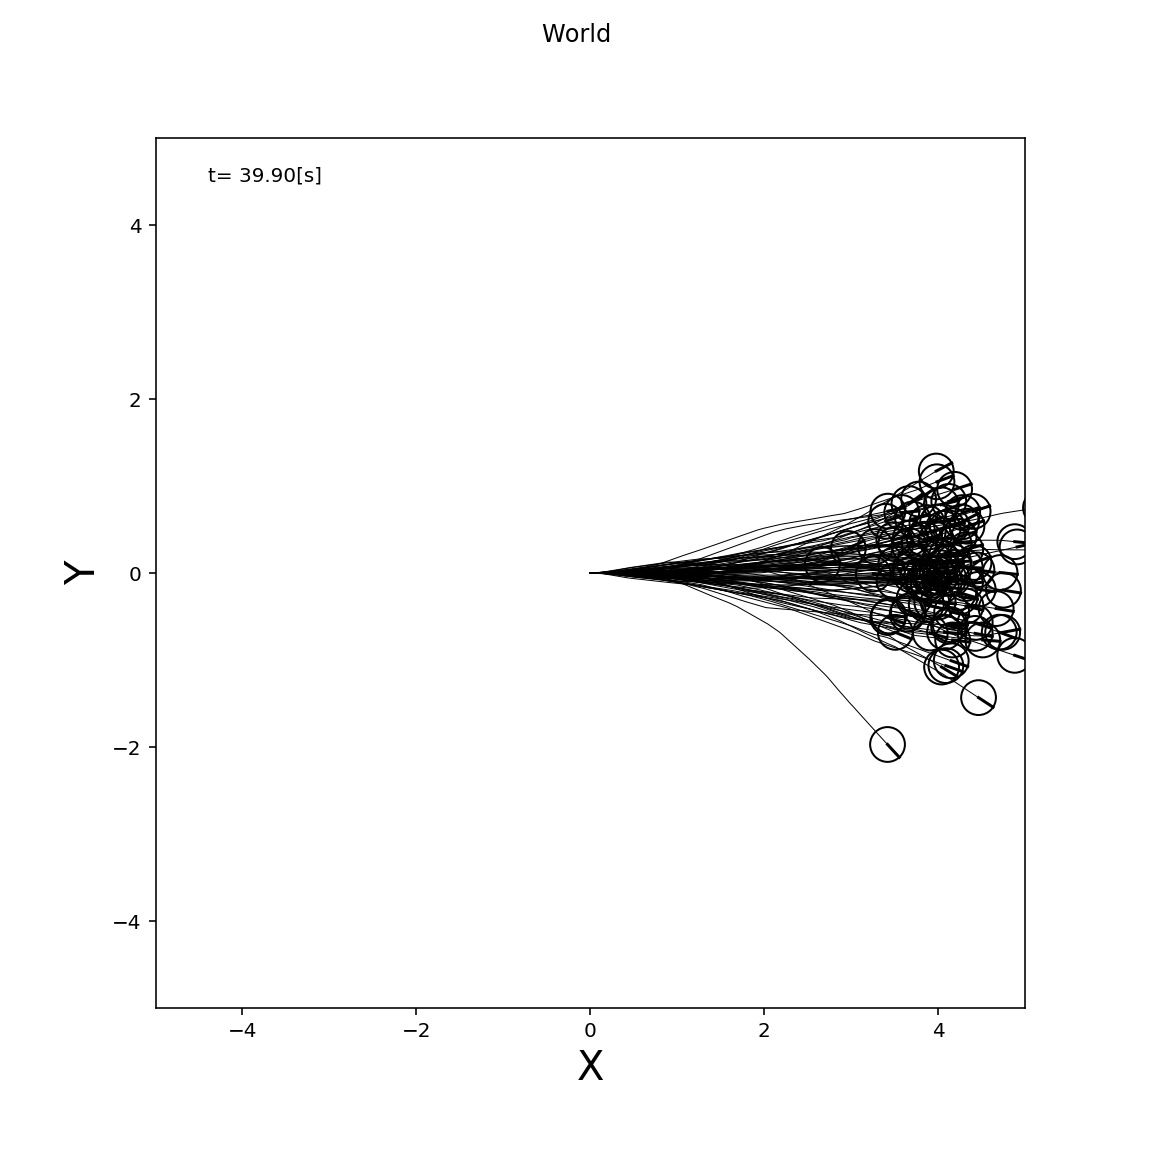

In [39]:
# 次はバイアスの影響を正規分布に当てはめる

world = worlds.World(40., 0.1, debuggable=False)

initial_pose = np.array([0.,0.,0.])


robots_ = []

for i in range(100):
    robot = robots.Robot(initial_pose, sensor=None, agent=agents.Agent(0.1, 0.0))
    world.append(robot)
    robots_.append(robot)
    
world.draw()

In [40]:
# 距離rと姿勢theta
poses = pd.DataFrame(
    [[math.sqrt(r.pose[0]**2 + r.pose[1]**2), r.pose[2]] for r in robots_],
    columns=['r', 'theta'])
poses.transpose()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
r,3.953364,3.877680,3.680880,3.757410,4.173327,5.374159,4.132485,3.914486,4.044972,3.688785,...,4.194005,3.920796,4.271299,4.904788,3.948859,3.868724,3.997552,4.187639,4.245897,4.138294
theta,-0.827605,0.574659,0.057283,0.614669,-0.192375,-0.093701,-0.094917,0.038931,0.098594,0.031829,...,-0.029276,0.269422,-0.143139,-0.097452,0.000821,0.249555,-0.042727,-0.220238,-0.125582,-0.095473


In [42]:
# 直進が直進に与えるばらつきの標準偏差
r_mean = poses['r'].mean()
r_var = poses['r'].var()
sigma_nu_nu = math.sqrt(r_var / r_mean)
print(sigma_nu_nu)

0.219659486388511


<IPython.core.display.Javascript object>


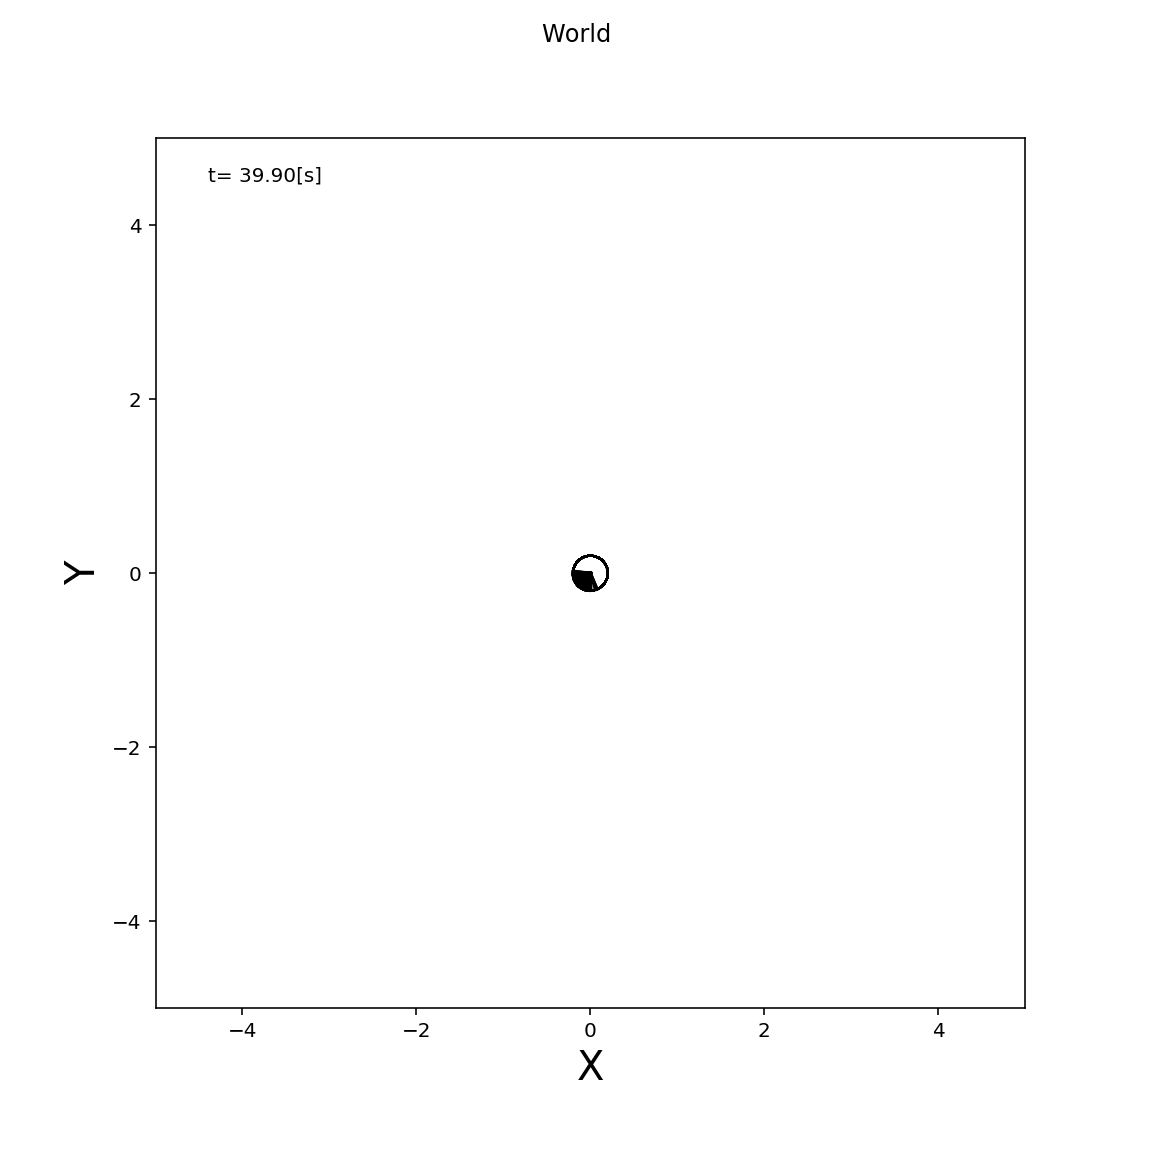

In [27]:
# 回転が回転にあたえるばらつきを求める
world = worlds.World(40.0, 0.1)  

initial_pose = np.array([0, 0, 0]).T
robots_ = []

for i in range(100):
    # 回転のみに指令が当たられたAgent
    r = robots.Robot(initial_pose, sensor=None, agent=agents.Agent(0.0, 0.1)) 
    world.append(r)
    robots_.append(r)

world.draw()

In [32]:
# 距離rと姿勢theta
poses = pd.DataFrame(
    [[math.sqrt(r.pose[0]**2 + r.pose[1]**2), r.pose[2]] for r in robots_],
    columns=['r', 'theta'])
poses.transpose()

# 回転が回転にあたえるばらつきの標準偏差
theta_mean = poses['theta'].mean()
theta_var = poses['theta'].var()
sigma_omega_omega = math.sqrt(theta_var / theta_mean)
print(sigma_omega_omega)

0.22581935235790918


<IPython.core.display.Javascript object>


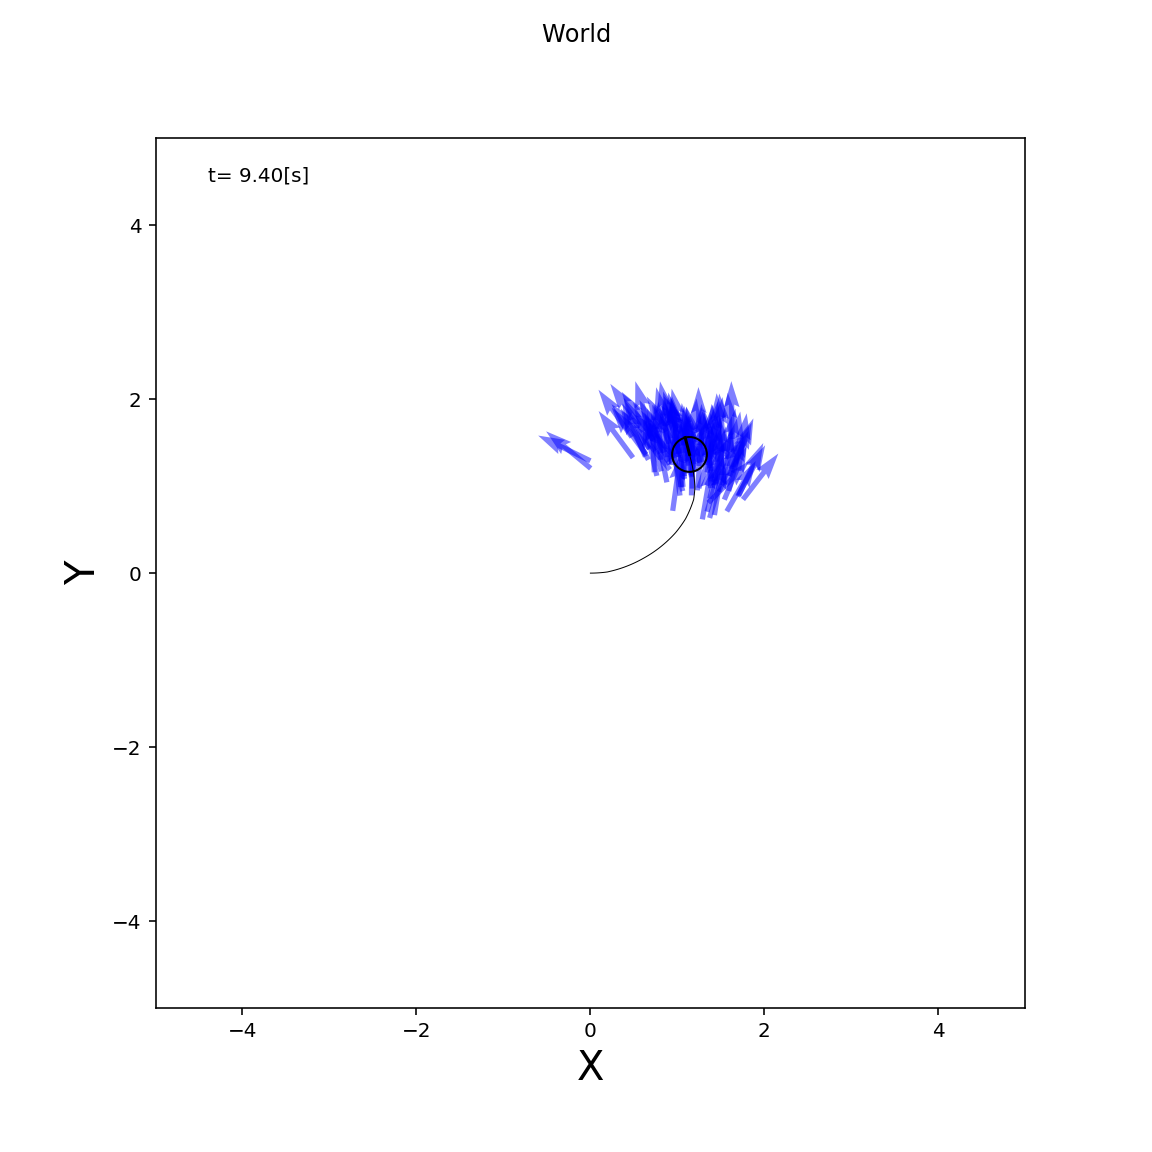

In [47]:
# このパラメータを使ってパーティクルを動かす
reload()
world = worlds.World(30., 0.1, debuggable=False)

initial_pose = np.array([0.,0.,0.])
# on以外は小さな値にしておく
estimator = estimators.Mcl(initial_pose, 100)
circling = agents.EstimationAgent(
    0.1, 0.2, 10./180.*np.pi, estimator=estimator)

robot = robots.Robot(initial_pose, sensor=None, agent=circling)
world.append(robot)
    
world.draw()

## まとめ

- $\sigma_{\nu \nu} = 0.253$
- $\sigma_{\nu \omega} = 0$
- $\sigma_{\omega \nu} = 0.115$
- $\sigma_{\omega \omega} = 0.226$

$\sigma_{\nu \omega} = 0$なのは，回転が直進へ与えるノイズを設定していないため